<a href="https://colab.research.google.com/github/Euan-J-Austin/Analytics_and_Intelligence/blob/main/Volkswagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The US EPA issued a Notice of Violation on 18-09-2015 ... https://www.epa.gov/sites/default/files/2015-10/documents/vw-nov-caa-09-18-15.pdf

Volkswagen has 'ordinary' shares (VOW in Germany, VWAGY in US) and 'preferred' shares (VOW3 in Germany, VWAPY in the US). 

VOW is relativley illiquid, held by investors who consider VOW a very long-term investment ... in 2014 VOW was held by Porsche Automobil Holding SE (around 30pc), Foriegn instiutional investors (around 28pc), Qatar Holding LLC (around 12pc), and State of Lower Saxony (around 10pc) ... the remaining being private shareholders/others/german institutional investors (around 15pc) ... https://annualreport2014.volkswagenag.com/group-management-report/shares-and-bonds/shareholder-structure.html#:~:text=SHAREHOLDER%20STRUCTURE%20AT%20DECEMBER%2031%2C%202014,-Volkswagen%20AG's%20subscribed&text=The%20second%2Dlargest%20shareholder%20was,were%20attributable%20to%20other%20shareholders.

So, I will look only at VOW3 and VWAPY and if necessary then analyse VOW 

VWAPY trades on OTCMKTS (using a dealer-broker network, stocks are not listed on major exchanges), and did so in 2015 ... as OTC is often used for small companies, will have to use comparable stocks also ... I have found OTC stocks with a similar market cap (but perhaps not in 2015, but that's enough for now I feel I'm sinking too much time into this) ...

In [ ]:
!pip install yfinance
!pip install tfcausalimpact

In [112]:
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [113]:
training_start = '2015-08-03'
training_end = '2015-09-17'
treatment_start = '2015-09-18'
treatment_end = '2015-09-22' #18th was a Friday, so gives us two bds 
end_stock = '2015-09-23'

In [114]:
y_vow3 =  yf.download(tickers = ['VOW3.DE'],
                start = training_start,
                end = end_stock,
                interval = "1d")['Adj Close'].rename('y_vow3')

y_vwapy = yf.download(tickers = ['VWAPY'],
                start = training_start,
                end = end_stock,
                interval = "1d")['Adj Close'].rename('y_vwapy')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [115]:
y_vow3[:1]

Date
2015-08-03    113.876068
Name: y_vow3, dtype: float64

In [116]:
y_vwapy[:1]

Date
2015-08-03    26.856293
Name: y_vwapy, dtype: float64

In [126]:
#avoiding other motor manufacturers

de_stocks = ['SIE.DE', 'DBK.DE', 'LHA.DE', 'EOAN.DE', 'ZAL.DE', 'BOSS.DE', 'GXI.DE']

otc_stocks = ['NOKBF', 'HKHHF', 'TSCDF', 'JAPAF', 'AAUKF', 'DASTY', 'DPSTF', 'BAYZF', 'FSUMF', 'NGGTF']

x_de = yf.download(tickers = de_stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")['Adj Close']

x_otc = yf.download(tickers = otc_stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")['Adj Close']

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  10 of 10 completed


In [127]:
x_de.head(1)

,BOSS.DE,DBK.DE,EOAN.DE,GXI.DE,LHA.DE,SIE.DE,ZAL.DE
Date,,,,,,,
2015-08-03,78.02272,26.031689,7.432925,60.629993,11.509657,76.385422,31.775


In [128]:
x_otc.head(1)

,AAUKF,BAYZF,DASTY,DPSTF,FSUMF,HKHHF,JAPAF,NGGTF,NOKBF,TSCDF
Date,,,,,,,,,,
2015-08-03,8.722178,111.627899,14.658381,23.448307,0.858296,64.075798,26.17979,9.536858,6.072911,2.051663


In [129]:
x_de = x_de.iloc[:, :len(de_stocks)]

x_otc = x_otc.iloc[:, :len(otc_stocks)]

In [130]:
#Removing time zones

x_de.index = x_de.index.tz_localize(None)
x_otc.index = x_otc.index.tz_localize(None)

In [131]:
x_otc.index

DatetimeIndex(['2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-17', '2015-08-18',
               '2015-08-19', '2015-08-20', '2015-08-21', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
               '2015-09-04', '2015-09-08', '2015-09-09', '2015-09-10',
               '2015-09-11', '2015-09-14', '2015-09-15', '2015-09-16',
               '2015-09-17', '2015-09-18', '2015-09-21', '2015-09-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [132]:
df_de = pd.concat([y_vow3, x_de], axis = 1).dropna()

df_otc = pd.concat([y_vwapy, x_otc], axis = 1).dropna()

# DATA ANALYSIS OF VOW3

In [134]:
df_de_training = df_de[df_de.index <= training_end]
df_de_training.tail(1)

,y_vow3,BOSS.DE,DBK.DE,EOAN.DE,GXI.DE,LHA.DE,SIE.DE,ZAL.DE
Date,,,,,,,,
2015-09-17,103.568604,72.037308,21.453659,5.010136,57.649502,10.999971,65.762794,29.17


In [135]:
def p_test(p):
  if p < 0.05:
    print(f"{p} stationary.")
  else: 
    print(f"{p} not stationary.")

p_test(adfuller(x = df_de_training.y_vow3)[1])

0.5343473738797779 not stationary.


In [136]:
differencing = df_de_training.pct_change().dropna()

In [137]:
differencing.head(1)

,y_vow3,BOSS.DE,DBK.DE,EOAN.DE,GXI.DE,LHA.DE,SIE.DE,ZAL.DE
Date,,,,,,,,
2015-08-04,-0.004065,0.032683,-0.025793,0.001244,-0.001463,-0.034622,-0.001215,0.021401


In [138]:
p_test(adfuller(x = differencing.y_vow3)[1])

2.2920334851529663e-07 stationary.


<Axes: >

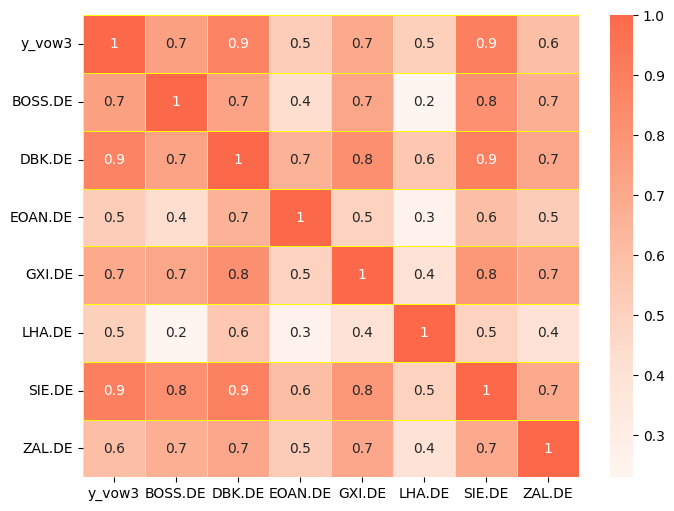

In [139]:
plt.figure(figsize = (8,6))
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'Reds',
            linecolor = 'yellow',
            linewidth = 0.65,
            center = True)


In [140]:
df_de_final = df_de
df_de_final

,y_vow3,BOSS.DE,DBK.DE,EOAN.DE,GXI.DE,LHA.DE,SIE.DE,ZAL.DE
Date,,,,,,,,
2015-08-03,113.876068,78.022720,26.031689,7.432925,60.629993,11.509657,76.385422,31.775000
2015-08-04,113.413155,80.572708,25.360247,7.442169,60.541294,11.111175,76.292580,32.455002
2015-08-05,116.437508,79.616463,25.559645,7.587007,59.982456,11.185311,77.445366,32.560001
2015-08-06,115.758568,80.006042,25.311413,7.559272,59.920357,11.291883,77.522728,32.185001
2015-08-07,116.746109,79.333130,25.034695,7.448333,59.583271,11.250181,76.741325,31.700001
2015-08-10,117.795403,80.324799,25.116083,7.405190,59.991322,11.338217,78.064308,31.650000
2015-08-11,113.444023,77.526871,24.611485,7.214128,59.086533,11.342851,75.781944,31.285000
2015-08-12,109.740738,74.622719,23.577866,7.189474,57.445484,11.264080,73.638855,30.695000
2015-08-13,110.141922,76.393555,23.883068,7.238781,57.906750,11.101907,74.226860,32.779999


In [141]:
#Pre-period and post-period

pre_period = [training_start, training_end]
post_period =[treatment_start, treatment_end]

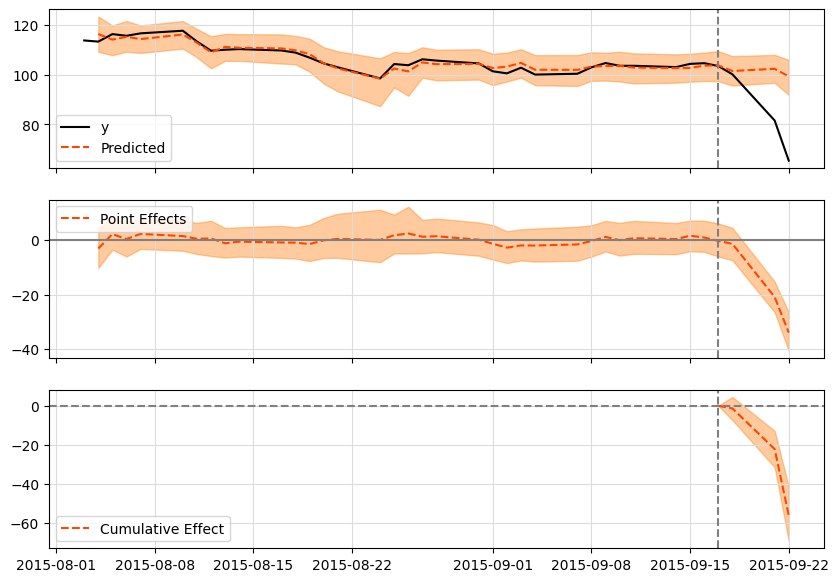

In [142]:
impact = CausalImpact(data = df_de_final,
                      pre_period = pre_period,
                      post_period = post_period)

impact.plot()

In [143]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 82.42. By contrast, in the absence of an
intervention, we would have expected an average response of 101.13.
The 95% interval of this counterfactual prediction is [95.94, 105.63].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -18.71 with a 95% interval of
[-23.21, -13.52]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 247.26.
By contrast, had the intervention not taken place, we would have expected
a sum of 303.38. The 95% interval of this prediction is [287.81, 316.88].


The above results are given in terms of absolute numbers. In relative
terms, the response v

# DATA ANALYSIS OF VWAGY

In [144]:
df_otc_training = df_otc[df_otc.index <= training_end]
df_otc_training.tail(1)

,y_vwapy,AAUKF,BAYZF,DASTY,DPSTF,FSUMF,HKHHF,JAPAF,NGGTF,NOKBF,TSCDF
Date,,,,,,,,,,,
2015-09-17,25.325449,8.451866,102.013275,13.938704,21.824963,0.947623,65.190536,23.00305,9.421172,5.755541,1.676958


In [145]:
p_test(adfuller(x = df_otc_training.y_vwapy)[1])

0.23183604327006374 not stationary.


In [146]:
differencing2 = df_otc_training.pct_change().dropna()

In [147]:
differencing2.head(1)

,y_vwapy,AAUKF,BAYZF,DASTY,DPSTF,FSUMF,HKHHF,JAPAF,NGGTF,NOKBF,TSCDF
Date,,,,,,,,,,,
2015-08-04,-0.007683,0.0,0.0,-0.003666,0.0,0.0,0.004538,-0.023149,0.0,-0.015537,-0.020958


In [148]:
p_test(adfuller(x = differencing2.y_vwapy)[1])

0.0003850269742806938 stationary.


<Axes: >

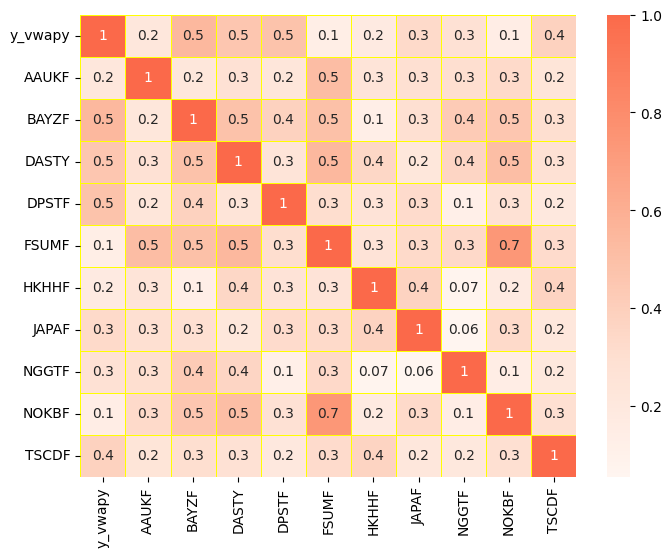

In [149]:
plt.figure(figsize = (8,6))
sns.heatmap(differencing2.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'Reds',
            linecolor = 'yellow',
            linewidth = 0.65,
            center = True)


In [154]:
df_final_otc = df_otc.drop(['AAUKF', 'FSUMF', 'HKHHF', 'NOKBF'], axis = 1)

df_final_otc.head(1)

,y_vwapy,BAYZF,DASTY,DPSTF,JAPAF,NGGTF,TSCDF
Date,,,,,,,
2015-08-03,26.856293,111.627899,14.658381,23.448307,26.17979,9.536858,2.051663


In [155]:
pre_period2 = [training_start, training_end]
post_period2 =[treatment_start, treatment_end]

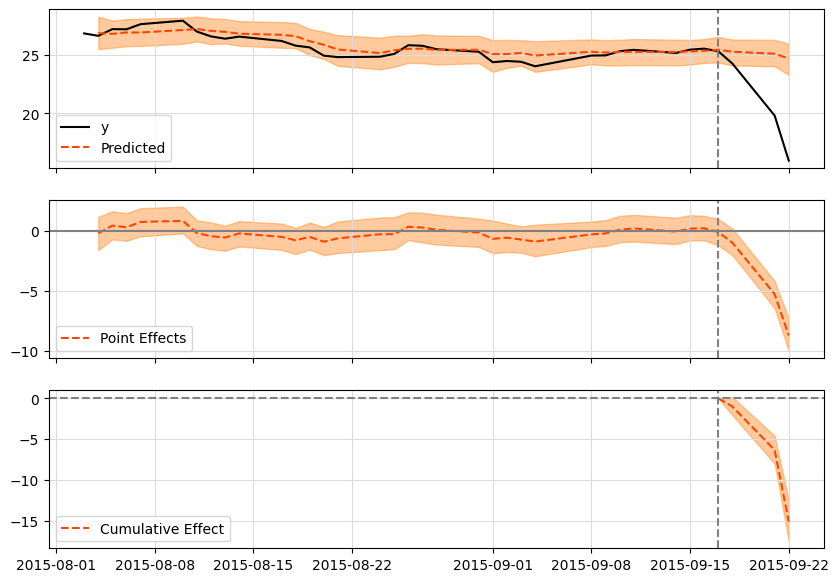

In [157]:
impact = CausalImpact(data = df_final_otc,
                      pre_period = pre_period2,
                      post_period = post_period2)

impact.plot()

In [158]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    20.02              60.05
Prediction (s.d.)         25.04 (0.41)       75.11 (1.24)
95% CI                    [24.16, 25.78]     [72.49, 77.35]

Absolute effect (s.d.)    -5.02 (0.41)       -15.07 (1.24)
95% CI                    [-5.77, -4.15]     [-17.3, -12.44]

Relative effect (s.d.)    -20.06% (1.65%)    -20.06% (1.65%)
95% CI                    [-23.04%, -16.56%] [-23.04%, -16.56%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [159]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 20.02. By contrast, in the absence of an
intervention, we would have expected an average response of 25.04.
The 95% interval of this counterfactual prediction is [24.16, 25.78].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -5.02 with a 95% interval of
[-5.77, -4.15]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 60.05.
By contrast, had the intervention not taken place, we would have expected
a sum of 75.11. The 95% interval of this prediction is [72.49, 77.35].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s